Files already downloaded and verified
Files already downloaded and verified
Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

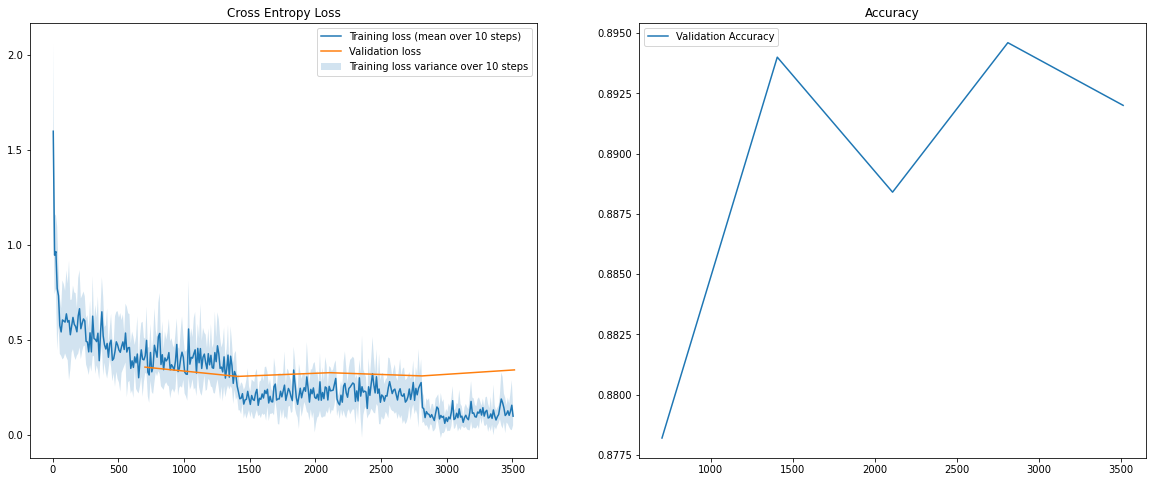

In [2]:
import utils
import typing
import time
import pathlib
import collections
import torch
import torchvision
import matplotlib.pyplot as plt
from trainer import compute_loss_and_accuracy
from dataloaders import load_cifar10


class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.resnet18(pretrained=True)

        self.model.fc = torch.nn.Linear(512, 10)  # No need to apply softmax,
        # as this is done in nn.CrossEntropyLoss
        for param in self.model.parameters():  # Freeze all parameters
            param.requires_grad = False
        for param in self.model.fc.parameters():  # Unfreeze the last fully-connected
            param.requires_grad = True  # layer
        for param in self.model.layer4.parameters():  # Unfreeze the last 5 convolutional
            param.requires_grad = True  # layers

    def forward(self, x):
        x = self.model(x)
        return x


class Trainer:
    def __init__(self,
                 batch_size: int,
                 learning_rate: float,
                 early_stop_count: int,
                 epochs: int,
                 model: torch.nn.Module,
                 dataloaders: typing.List[torch.utils.data.DataLoader]):
        """
            Initialize our trainer class.
        """
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.early_stop_count = early_stop_count
        self.epochs = epochs

        # Since we are doing multi-class classification, we use CrossEntropyLoss
        self.loss_criterion = torch.nn.CrossEntropyLoss()
        # Initialize the model
        self.model = model
        # Transfer model to GPU VRAM, if possible.
        self.model = utils.to_cuda(self.model)
        print(self.model)

        # Define our optimizer. SGD = Stochastich Gradient Descent
        self.optimizer = torch.optim.Adam(self.model.parameters(),
                                         self.learning_rate)

        # Load our dataset
        self.dataloader_train, self.dataloader_val, self.dataloader_test = dataloaders

        # Validate our model everytime we pass through 50% of the dataset
        self.num_steps_per_val = len(self.dataloader_train) // 2
        self.global_step = 0
        self.start_time = time.time()

        # Tracking variables
        self.train_history = dict(
            loss=collections.OrderedDict(),
            accuracy=collections.OrderedDict()

        )
        self.validation_history = dict(
            loss=collections.OrderedDict(),
            accuracy=collections.OrderedDict()
        )
        self.test_history = dict(
            loss=collections.OrderedDict(),
            accuracy=collections.OrderedDict()
        )
        self.checkpoint_dir = pathlib.Path("checkpoints")

    def validation_step(self):
        """
            Computes the loss/accuracy for all three datasets.
            Train, validation and test.
        """
        self.model.eval()
        validation_loss, validation_acc = compute_loss_and_accuracy(
            self.dataloader_val, self.model, self.loss_criterion
        )
        self.validation_history["loss"][self.global_step] = validation_loss
        self.validation_history["accuracy"][self.global_step] = validation_acc
        
        #test
        test_loss, test_acc = compute_loss_and_accuracy(
            self.dataloader_test, self.model, self.loss_criterion
        )
        self.test_history["loss"][self.global_step] = test_loss
        self.test_history["accuracy"][self.global_step] = test_acc
        
        used_time = time.time() - self.start_time
        print(
            f"Epoch: {self.epoch:>1}",
            f"Batches per seconds: {self.global_step / used_time:.2f}",
            f"Global step: {self.global_step:>6}",
            f"Validation Loss: {validation_loss:.2f}",
            f"Validation Accuracy: {validation_acc:.3f}",
            f"test Loss: {test_loss:.2f}",
            f"Test Accuracy: {test_acc:.3f}",
            sep=", ")
        self.model.train()

    def should_early_stop(self):
        """
            Checks if validation loss doesn't improve over early_stop_count epochs.
        """
        # Check if we have more than early_stop_count elements in our validation_loss list.
        val_loss = self.validation_history["loss"]
        if len(val_loss) < self.early_stop_count:
            return False
        # We only care about the last [early_stop_count] losses.
        relevant_loss = list(val_loss.values())[-self.early_stop_count:]
        first_loss = relevant_loss[0]
        if first_loss == min(relevant_loss):
            print("Early stop criteria met")
            return True
        return False

    def train_step(self, X_batch, Y_batch):
        """
        Perform forward, backward and gradient descent step here.
        The function is called once for every batch (see trainer.py) to perform the train step.
        The function returns the mean loss value which is then automatically logged in our variable self.train_history.

        Args:
            X: one batch of images
            Y: one batch of labels
        Returns:
            loss value (float) on batch
        """
        # X_batch is the CIFAR10 images. Shape: [batch_size, 3, 32, 32]
        # Y_batch is the CIFAR10 image label. Shape: [batch_size]
        # Transfer images / labels to GPU VRAM, if possible
        X_batch = utils.to_cuda(X_batch)
        Y_batch = utils.to_cuda(Y_batch)

        # Perform the forward pass
        predictions = self.model(X_batch)
        # Compute the cross entropy loss for the batch
        loss = self.loss_criterion(predictions, Y_batch)
        # Backpropagation
        loss.backward()
        # Gradient descent step
        self.optimizer.step()
        # Reset all computed gradients to 0
        self.optimizer.zero_grad()

        return loss.detach().cpu().item()

    def train(self):
        """
        Trains the model for [self.epochs] epochs.
        """
        def should_validate_model():
            return self.global_step % self.num_steps_per_val == 0

        for epoch in range(self.epochs):
            self.epoch = epoch
            # Perform a full pass through all the training samples
            for X_batch, Y_batch in self.dataloader_train:
                loss = self.train_step(X_batch, Y_batch)
                self.train_history["loss"][self.global_step] = loss
                self.global_step += 1
                # Compute loss/accuracy for validation set
                if should_validate_model():
                    self.validation_step()
                    self.save_model()
                    if self.should_early_stop():
                        print("Early stopping.")
                        return

    def save_model(self):
        def is_best_model():
            """
                Returns True if current model has the lowest validation loss
            """
            val_loss = self.validation_history["loss"]
            validation_losses = list(val_loss.values())
            return validation_losses[-1] == min(validation_losses)

        state_dict = self.model.state_dict()
        filepath = self.checkpoint_dir.joinpath(f"{self.global_step}.ckpt")

        utils.save_checkpoint(state_dict, filepath, is_best_model())

    def load_best_model(self):
        state_dict = utils.load_best_checkpoint(self.checkpoint_dir)
        if state_dict is None:
            print(
                f"Could not load best checkpoint. Did not find under: {self.checkpoint_dir}")
            return
        self.model.load_state_dict(state_dict)

def create_plots(trainer: Trainer, name: str):
    plot_path = pathlib.Path("plots")
    plot_path.mkdir(exist_ok=True)
    # Save plots and show them
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title("Cross Entropy Loss")
    utils.plot_loss(trainer.train_history["loss"], label="Training loss", npoints_to_average=10)
    utils.plot_loss(trainer.validation_history["loss"], label="Validation loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    utils.plot_loss(trainer.validation_history["accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.savefig(plot_path.joinpath(f"{name}_plot.png"))
    plt.show()

if __name__ == "__main__":
    # Set the random generator seed (parameters, shuffling etc).
    # You can try to change this and check if you still get the same result!
    utils.set_seed(0)
    epochs = 10
    batch_size = 32
    learning_rate = 5e-4
    early_stop_count = 4
    dataloaders = load_cifar10(batch_size)
    model = Model()
    trainer = Trainer(
        batch_size,
        learning_rate,
        early_stop_count,
        epochs,
        model,
        dataloaders
    )
    trainer.train()
    create_plots(trainer, "task4")
    